# %%[markdown]

 # Test Ensemble Interfaces

 Sabina's notebooks:
 * [18-month epi evaluation ensemble challenge](https://github.com/ciemss/program-milestones/tree/12-epi-ensemble-challenge/18-month-milestone/evaluation/Epi_Ensemble_Challenge)
 * [12-month epi evaluation ensemble challenge](https://github.com/ciemss/pyciemss/tree/sa-ensemble-eval/notebook/ensemble_eval_sa)

In [ ]:
# %%

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tabulate import tabulate
from tqdm import tqdm

import pyciemss
from pyciemss.integration_utils.result_processing import cdc_format
from mira.modeling.viz import GraphicalModel
from mira.sources.amr.petrinet import template_model_from_amr_json

In [ ]:
# %%

MODEL_PATH = "./data/18m_eval/models"
DATASET_PATH = "./data/18m_eval/datasets"

In [ ]:
# %%

# Models
model_paths = [
    os.path.join(MODEL_PATH, 'SEIRHD_age_structured_petrinet.json'),
    os.path.join(MODEL_PATH, 'SEIRHD_vacc_var_petrinet.json'),
    os.path.join(MODEL_PATH, 'SEIRHD_base_petrinet.json'),
]

In [ ]:
# %%

# Select calibration dataset

location = 'New York State'
start_date = '2021-06-01'
end_date = '2021-09-06'

full_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'full_dataset.csv'))
full_dataset = full_dataset.sort_values(by = 'date').reset_index(drop = True)
dataset = full_dataset[(full_dataset.date >= start_date) & (full_dataset.date < end_date)].reset_index(drop = True).reset_index(names = ['Timestamp'])

# Drop date because pyciemss rejects them
dataset = dataset.drop(labels = 'date', axis = 1)

print(tabulate(dataset, headers = 'keys'))

      Timestamp     Infected    Hospitalized    Dead
--  -----------  -----------  --------------  ------
 0            0  2.10287e+06          136862   53123
 1            1  2.10327e+06          136968   53132
 2            2  2.10377e+06          137089   53151
 3            3  2.10454e+06          137179   53207
 4            4  2.10538e+06          137249   53221
 5            5  2.10588e+06          137328   53254
 6            6  2.1064e+06           137422   53265
 7            7  2.10685e+06          137534   53275
 8            8  2.10729e+06          137614   53283
 9            9  2.10783e+06          137709   53296
10           10  2.10851e+06          137788   53313
11           11  2.10895e+06          137837   53330
12           12  2.10931e+06          137923   53340
13           13  2.10968e+06          138001   53349
14           14  2.11e+06             138068   53365
15           15  2.11031e+06          138133   53367
16           16  2.11076e+06          138205  

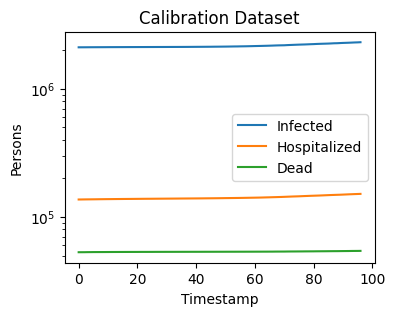

In [ ]:
# %%

fig, ax = plt.subplots(1, 1, figsize = (4, 3))
for c in dataset.columns:
    if c not in ('Timestamp', 'date'):
        __ = ax.plot(dataset['Timestamp'], dataset[c], label = c)
__ = plt.setp(ax, yscale = 'log', xlabel = 'Timestamp', ylabel = 'Persons', title = 'Calibration Dataset')
__ = ax.legend()

In [ ]:
# %%

# Settings

num_iterations = 20
num_samples =  200
start_time = 0.0
end_time = len(dataset) + 28.0 + 1.0
logging_step_size = 1.0

In [ ]:
# %%

# Mapping model outputs (observables) of each model to ensemble model outputs
def solution_mapping(model_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Susceptible"] = model_solution["susceptible"]
    mapped_dict["Exposed"] = model_solution["exposed"]
    mapped_dict["Infected"] = model_solution["infected"]
    mapped_dict["Recovered"] = model_solution["recovered"]
    mapped_dict["Hospitalized"] = model_solution["hospitalized"]
    mapped_dict["Deceased"] = model_solution["deceased"]
    mapped_dict["Cumulative_cases"] = model_solution["cumulative_cases"]
    mapped_dict["Cumulative_hosp"] = model_solution["cumulative_hosp"]
    return mapped_dict

In [ ]:
# %%

# Mapping from dataset features to model outputs (observables)
data_mapping = {
    'Infected': 'Cumulative_cases',
    'Hospitalized': 'Cumulative_hosp',
    'Dead': 'Deceased'
}

In [ ]:
# %%

# Calibrate each model as a single-model ensemble

results = {}
results['single_simulate_precalibrate'] = []
results['single_calibrate'] = []
results['single_simulate_postcalibrate'] = []

for i, p in tqdm(enumerate(model_paths)):

    # Step 1: simulate each model before calibration
    r = pyciemss.ensemble_sample(
        model_paths_or_jsons = [p],
        solution_mappings = [solution_mapping],
        start_time = start_time,
        end_time = end_time,
        logging_step_size = logging_step_size,
        num_samples = num_samples,
        dirichlet_alpha = torch.ones(1)
    )
    results['single_simulate_precalibrate'].append(r)

    # Step 2: calibrate each model
    r = pyciemss.ensemble_calibrate(
        model_paths_or_jsons = [p], 
        solution_mappings = [solution_mapping],
        data_path = dataset,
        data_mapping = data_mapping,
        num_iterations = num_iterations
    )
    results['single_calibrate'].append(r)

    # Simulate each model after calibration
    rr = pyciemss.ensemble_sample(
        model_paths_or_jsons = [p],
        solution_mappings = [solution_mapping],
        start_time = start_time,
        end_time = end_time,
        logging_step_size = logging_step_size,
        num_samples = num_samples,
        inferred_parameters = r['inferred_parameters']
    )
    results['single_simulate_postcalibrate'].append(rr)

0it [00:00, ?it/s]/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 96 rows of data. The first column, Timestamp, begins at 0 and ends at 96. The subsequent columns are named: Infected, Hospitalized, Dead


1it [00:49, 49.02s/it]/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 96 rows of data. The first column, Timestamp, begins at 0 and ends at 96. The subsequent columns are named: Infected, Hospitalized, Dead


2it [01:21, 39.10s/it]/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 96 rows of data. The first column, Timestamp, begins at 0 and ends at 96. The subsequent columns are named: Infected, Hospitalized, Dead


3it [01:29, 29.92s/it]
3it [01:29, 29.92s/it]


In [ ]:
# %%

# Repeat for ensemble model
#
# Step 1: simulate ensemble before calibration
results['ensemble_simulate_precalibrate'] = pyciemss.ensemble_sample(
    model_paths_or_jsons = model_paths,
    solution_mappings = [solution_mapping, solution_mapping, solution_mapping],
    start_time = start_time,
    end_time = end_time,
    logging_step_size = logging_step_size,
    num_samples = num_samples,
    dirichlet_alpha = torch.tensor([1.0, 1.0, 1.0])
)

In [ ]:
# %%

# Step 2: calibrate ensemble
results['ensemble_calibrate'] = pyciemss.ensemble_calibrate(
    model_paths_or_jsons = model_paths, 
    solution_mappings = [solution_mapping, solution_mapping, solution_mapping],
    data_path = dataset,
    data_mapping = data_mapping,
    num_iterations = num_iterations
)

/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 96 rows of data. The first column, Timestamp, begins at 0 and ends at 96. The subsequent columns are named: Infected, Hospitalized, Dead


In [ ]:
# %%

# Step 3: simulate ensemble after calibration
results['ensemble_simulate_postcalibrate'] = pyciemss.ensemble_sample(
    model_paths_or_jsons = model_paths,
    solution_mappings = [solution_mapping, solution_mapping, solution_mapping],
    start_time = start_time,
    end_time = end_time,
    logging_step_size = logging_step_size,
    num_samples = num_samples,
    inferred_parameters = results['ensemble_calibrate']['inferred_parameters']
)

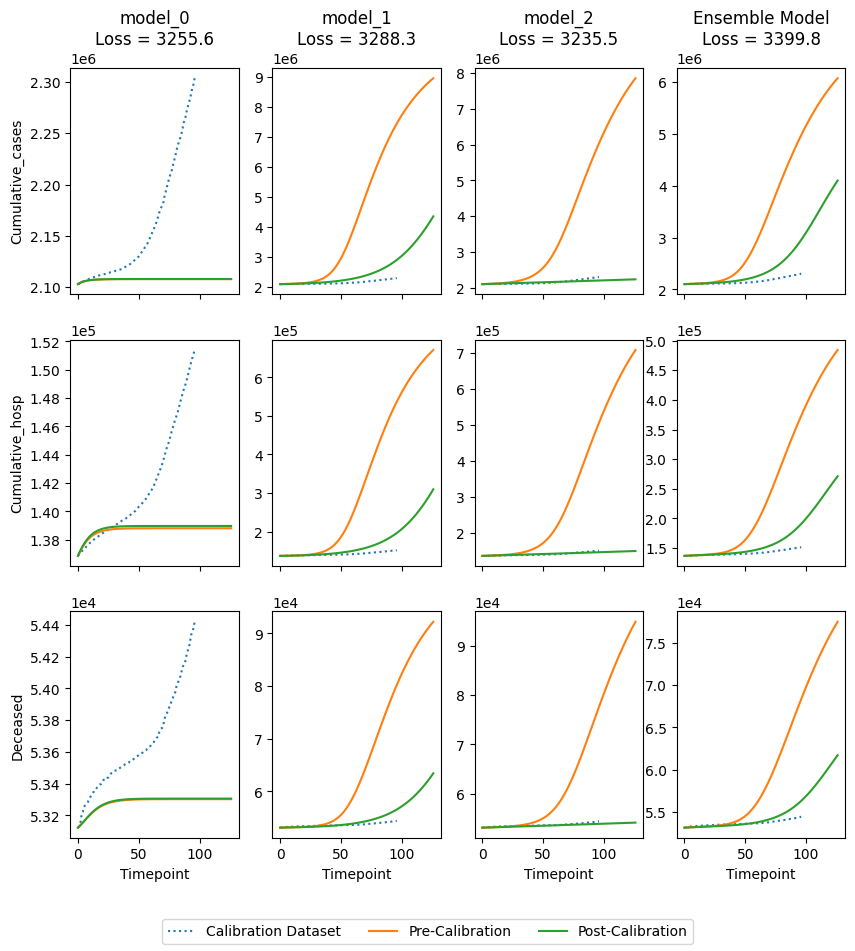

In [ ]:
# %%

# Plot results

fig, axes = plt.subplots(3, 4, figsize = (10, 10))
for i, (v, c) in enumerate(data_mapping.items()):
    for j in range(4):
        ax = axes[i, j]

        # Calibration data
        x = dataset['Timestamp']
        y = dataset[v]
        h0, = ax.plot(x, y, linestyle = ':', label = 'Calibration Dataset')

        # Single models
        if j < 3:

            # Pre-calibration
            r = results['single_simulate_precalibrate'][j]['data']
            r = r.groupby(['timepoint_id']).aggregate('mean').reset_index()
            x = r['timepoint_unknown']
            y = r[f'{c}_state']
            __  = ax.plot(x, y, label = 'Pre-calibration')

            # Post-calibration
            r = results['single_simulate_postcalibrate'][j]['data']
            r = r.groupby(['timepoint_id']).aggregate('mean').reset_index()
            x = r['timepoint_unknown']
            y = r[f'{c}_state']
            __  = ax.plot(x, y, label = 'Post-Calibration')

        # Ensemble model
        else:
            # Pre-calibration
            r = results['ensemble_simulate_precalibrate']['data']
            r = r.groupby(['timepoint_id']).aggregate('mean').reset_index()
            x = r['timepoint_unknown']
            y = r[f'{c}_state']
            h1,  = ax.plot(x, y, label = 'Pre-calibration')

            # Post-calibration
            r = results['ensemble_simulate_postcalibrate']['data']
            r = r.groupby(['timepoint_id']).aggregate('mean').reset_index()
            x = r['timepoint_unknown']
            y = r[f'{c}_state']
            h2,  = ax.plot(x, y, label = 'Post-Calibration')

        # Formatting
        ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
        if i == 0:
            if j < 3:
                l = results['single_calibrate'][j]['loss']
                __ = plt.setp(ax, title = f'model_{j}\nLoss = {l:.1f}')
            else:
                l = results['ensemble_calibrate']['loss']
                __ = plt.setp(ax, title = f'Ensemble Model\nLoss = {l:.1f}')
        elif i == 2:
            __ = plt.setp(ax, xlabel = 'Timepoint')
        if i != 2:
            __ = ax.tick_params(labelbottom = False)
        if j == 0:
            __ = plt.setp(ax, ylabel = c)

__ = fig.legend([h0, h1, h2], ['Calibration Dataset',  'Pre-Calibration',  'Post-Calibration'], loc = 'lower center', ncols = 3)

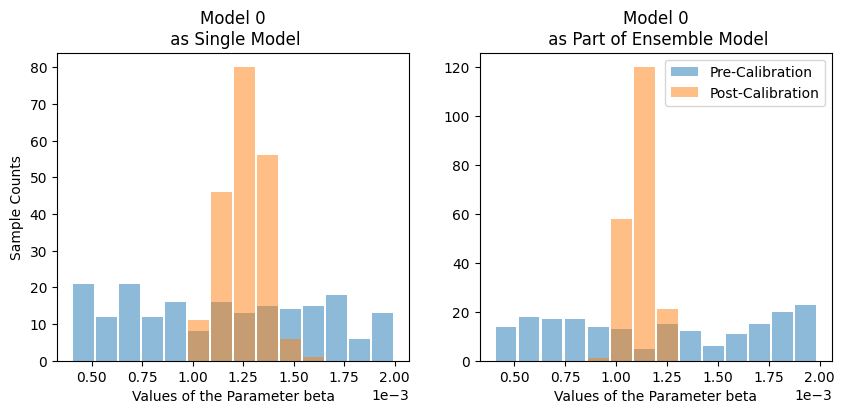

In [ ]:
# %%

# Plot prior/posterior distributions

# Pick a single model and one of its parameters
j = 0
param = 'beta'

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

# Single model
ax = axes[0]

# Before calibration
r = results['single_simulate_precalibrate'][j]['data'].groupby(['sample_id']).aggregate('mean').reset_index()
d = r[f'model_{j}/persistent_{param}_param']
c, b = np.histogram(d, bins = int(np.sqrt(num_samples)))
x = 0.5 * (b[1:] + b[:-1])
w = 0.9 * (b[1] - b[0])
h0 = ax.bar(x, c, width = w, align = 'center', alpha = 0.5, label = 'Pre-calibration')

# After calibration
r = results['single_simulate_postcalibrate'][j]['data'].groupby(['sample_id']).aggregate('mean').reset_index()
d = r[f'model_{j}/persistent_{param}_param']
c, b = np.histogram(d, bins = b)
x = 0.5 * (b[1:] + b[:-1])
w = 0.9 * (b[1] - b[0])
h1 = ax.bar(x, c, width = w, align = 'center', alpha = 0.5, label = 'Post-calibration')


# Ensemble model
ax = axes[1]

# Before calibration
r = results['ensemble_simulate_precalibrate']['data'].groupby(['sample_id']).aggregate('mean').reset_index()
d = r[f'model_{j}/persistent_{param}_param']
c, b = np.histogram(d, bins = int(np.sqrt(num_samples)))
x = 0.5 * (b[1:] + b[:-1])
w = 0.9 * (b[1] - b[0])
__ = ax.bar(x, c, width = w, align = 'center', alpha = 0.5, label = 'Post-calibration')

# After calibration
r = results['ensemble_simulate_postcalibrate']['data'].groupby(['sample_id']).aggregate('mean').reset_index()
d = r[f'model_{j}/persistent_{param}_param']
c, b = np.histogram(d, bins = b)
x = 0.5 * (b[1:] + b[:-1])
w = 0.9 * (b[1] - b[0])
h1 = ax.bar(x, c, width = w, align = 'center', alpha = 0.5, label = 'Post-calibration')

axes[0].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0, 0))
axes[1].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0, 0))
__ = plt.setp(axes[0], title = f'Model {j}\n as Single Model', xlabel = f'Values of the Parameter {param}', ylabel = 'Sample Counts')
__ = plt.setp(axes[1], title = f'Model {j}\n as Part of Ensemble Model', xlabel = f'Values of the Parameter {param}')
__ = ax.legend([h0, h1], ['Pre-Calibration', 'Post-Calibration'], loc = 'best', ncols = 1)

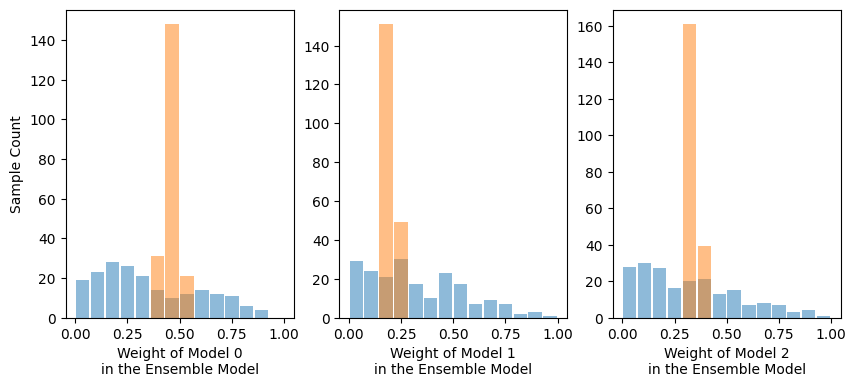

In [ ]:
# %%

# Model weight distributions

fig, axes = plt.subplots(1, 3, figsize = (10, 4))
for j, __ in enumerate(model_paths):
    ax = axes[j]

    # Before calibration
    r = results['ensemble_simulate_precalibrate']['data'].groupby(['sample_id']).aggregate('mean').reset_index()
    c, b = np.histogram(r[f'model_{j}/weight_param'], bins = int(np.sqrt(num_samples)), range = (0, 1))
    x = 0.5 * (b[1:] + b[:-1])
    w = 0.9 * (b[1] - b[0])
    __ = ax.bar(x, c, width = w, align = 'center', alpha = 0.5)

    # After calibration
    r = results['ensemble_simulate_postcalibrate']['data'].groupby(['sample_id']).aggregate('mean').reset_index()
    c, b = np.histogram(r[f'model_{j}/weight_param'], bins = int(np.sqrt(num_samples)), range = (0, 1))
    x = 0.5 * (b[1:] + b[:-1])
    w = 0.9 * (b[1] - b[0])
    __ = ax.bar(x, c, width = w, align = 'center', alpha = 0.5)


    __ = plt.setp(ax, xlabel = f'Weight of Model {j}\nin the Ensemble Model')
    if j == 0:
        __ = plt.setp(ax, ylabel = 'Sample Count')

In [ ]:
# %%

# CDC Data Formatting

ensemble_dataset = cdc_format(
    results['ensemble_simulate_postcalibrate']['ensemble_quantiles'],
    # solution_string_mapping = {v: v for k, v in data_mapping.items()},
    solution_string_mapping = {
        'Deceased_state': 'cum death'
    },
    forecast_start_date = end_date,
    location = location,
    drop_column_names = ['timepoint_id', 'number_days', 'output'],
    train_end_point = len(dataset) - 1.0
)
ensemble_dataset = ensemble_dataset.reset_index(drop = True)

print(tabulate(ensemble_dataset.head(10), headers = 'keys'))

    type        quantile    value  target                     forecast_date        target_end_date      location
--  --------  ----------  -------  -------------------------  -------------------  -------------------  --------------
 0  quantile       0.01   55521.1  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 1  quantile       0.025  55592.9  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 2  quantile       0.05   55688.4  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 3  quantile       0.1    55802.3  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 4  quantile       0.15   55903.6  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 5  quantile       0.2    55994.2  1.0 days ahead  cum death  2021-09-06 00:00:00  2021-09-07 00:00:00  New York State
 6  quantile       0.25   56041.9  1.0 days ahead  cum

/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/result_processing.py:269: UserWarning: cdc_format only works for time_unit=daystime_unit will default to days and overwrite previous time_unit.
  warnings.warn(
/Users/nliu/Workspace/projects/uncharted/askem/pyciemss/pyciemss/integration_utils/result_processing.py:324: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


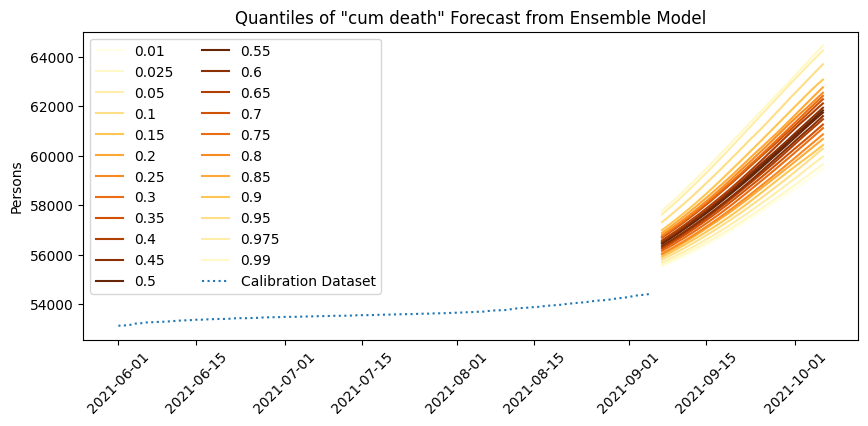

In [ ]:
# %%

# Plot CDC data

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

# Calibrated Ensemble Forecast
quantiles = ensemble_dataset['quantile'].unique()
num_quantiles = len(quantiles)
colors = [mpl.colormaps.get_cmap('YlOrBr')(i) for i in np.linspace(0, 1, int(0.5 * (num_quantiles + 1)))]
colors += [mpl.colormaps.get_cmap('YlOrBr_r')(i) for i in np.linspace(0, 1, int(0.5 * (num_quantiles + 1)))]
for i, q in enumerate(quantiles):
    c = colors[i]
    r = ensemble_dataset[ensemble_dataset['quantile'] == q]

    x = r['target_end_date']
    y = r['value']
    __ = ax.plot(x, y, color = c, label = f'{q}')


# Calibration dataset
x = np.arange(np.datetime64(start_date), np.datetime64(end_date), np.timedelta64(1, 'D'))
y = dataset['Dead']
__ = ax.plot(x, y, linestyle = ':', label = 'Calibration Dataset')

# Formatting
ax.tick_params('x', labelrotation = 45.0)
__ = plt.setp(ax, ylabel = 'Persons', title = 'Quantiles of "cum death" Forecast from Ensemble Model')
__ = ax.legend(ncols = 2)